# Project LSK data onto Dahlin Landscape
## Xiaonan Wang
## 17Feb2021

Project the data onto the Dahlin landscape ([Dahlin et al., Blood 2018](https://pubmed.ncbi.nlm.nih.gov/29588278/)).

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.7.0 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [35]:
# Here we need to keep the normalisation consistent
adata_hvg = sc.read('./write/patel_smq2_LSK_processed_regressout_cellcycle.h5ad')
adata = sc.read('./write/patel_smq2_LSK_raw.h5ad')
adata.obs = adata_hvg.obs
del adata_hvg
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

filtered out 6525 genes that are detected in less than 1 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [3]:
ref_data = sc.read('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/Niki_10X_data/WT_10X_data/niki_passQC_norm_10K.h5ad')
ref_data = ref_data[ref_data.obs['CellSubType'] !='Unknown',:].copy()
ref_hvg = np.genfromtxt('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/Niki_10X_data/WT_10X_data/gene_names.txt', dtype=str)

ref_data.obs['CellSubType'] =  ref_data.obs['CellSubType'].astype('category')
ref_data.obs['CellSubType'] =ref_data.obs['CellSubType'].cat.reorder_categories(['HSCs', 'Immatur', 'Lymphoi','MEP','Megakry','Early e','Middle ','Late er', 'Basophi', 'Neutrop'])
ref_data.obs['CellSubType'] =ref_data.obs['CellSubType'].cat.rename_categories(['HSC', 'Immature', 'Lymphoid', 'MEP', 'Megakaryocyte', 'Early erythoid', 'Middle erythoid', 'Late erythoid', 'Basophil', 'Neutrophil'])

In [4]:
OLG = np.intersect1d(ref_hvg, adata.var_names)
print(len(OLG))
adata = adata[:,OLG].copy()
ref_data = ref_data[:,OLG].copy()

sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
sc.pp.normalize_per_cell(ref_data, counts_per_cell_after=10000)

sc.pp.log1p(adata)
sc.pp.log1p(ref_data)

sc.pp.scale(adata)
sc.pp.scale(ref_data)

4489


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [5]:
print(adata.shape)
print(ref_data.shape)

(2554, 4489)
(44321, 4489)


In [6]:
from sklearn.decomposition import PCA
pca_ = PCA(n_components=50, svd_solver='auto', random_state=0)

In [7]:
pca_.fit(ref_data.X)

PCA(n_components=50, random_state=0)

In [8]:
X_pca1 = pca_.transform(ref_data.X)
X_pca2 = pca_.transform(adata.X)

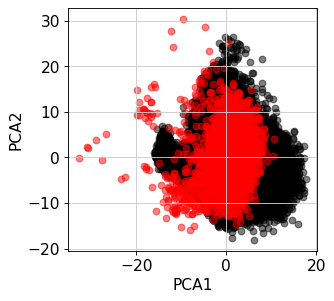

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X_pca1[:,0], X_pca1[:,1], c='black', alpha=0.5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
ax1.scatter(X_pca2[:,0], X_pca2[:,1], c='red', alpha=0.5)
plt.show()

In [10]:
from sklearn.metrics.pairwise import euclidean_distances
D_sub = euclidean_distances(X_pca2, X_pca1)

In [11]:
print(X_pca1.shape)
print(X_pca2.shape)
print(D_sub.shape)

(44321, 50)
(2554, 50)
(2554, 44321)


In [12]:
from collections import defaultdict
cl_assigned = []
Rstore = defaultdict(list) # dictionary to store results
for i in range(D_sub.shape[0]):
    CellDis = D_sub[i,:]
    CellDis_sorted = np.argsort(CellDis)[:15]
    cl_assigned.append(np.in1d(range(len(CellDis)), CellDis_sorted))
    Rstore['MinDist'].append(np.min(CellDis[CellDis_sorted]))
    Rstore['MedianDist'].append(np.median(CellDis[CellDis_sorted]))
    Rstore['MaxDist'].append(np.max(CellDis[CellDis_sorted]))
    Rstore['SD'].append(np.std(CellDis[CellDis_sorted]))
    Rstore['Dahlin_CT'].append(ref_data[CellDis_sorted,:].obs['CellSubType'].value_counts().index[0])
Rstore = pd.DataFrame.from_dict(Rstore)
Rstore.index = adata.obs_names

In [13]:
cl_assigned = np.vstack(cl_assigned)
print(cl_assigned.shape)

(2554, 44321)


In [14]:
Rstore.head(3)

,MinDist,MedianDist,MaxDist,SD,Dahlin_CT
RBG25049,8.173332,9.804525,10.374080,0.585465,Immature
RBG25050,9.459538,10.640797,11.081947,0.467073,HSC
RBG25051,8.958900,10.204933,10.637304,0.479166,Immature


In [15]:
Rstore.to_csv('Proj_results_dahlin.csv')

In [16]:
def Obs_sublabels(ref_data, proj_data, proj_data_obs, cl_assigned, prefix):
    CT = np.unique(proj_data.obs[proj_data_obs])
    print(CT)
    for ct in CT:
        idx = proj_data.obs[proj_data_obs] == ct
        ca_new = cl_assigned[idx,:]
        ref_data.obs[prefix+'_'+ct] = np.log2(np.sum(ca_new, axis=0)+1)

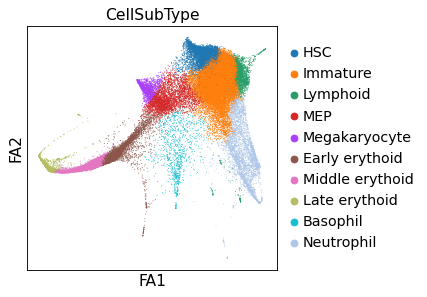

In [17]:
sc.pl.draw_graph(ref_data, color='CellSubType', legend_loc="right margin", color_map=cmap)

In [36]:
Obs_sublabels(ref_data, adata, 'leiden_v1', cl_assigned, 'SubLC')

['0' '1' '10' '2' '3' '4' '5' '6' '7' '8' '9']


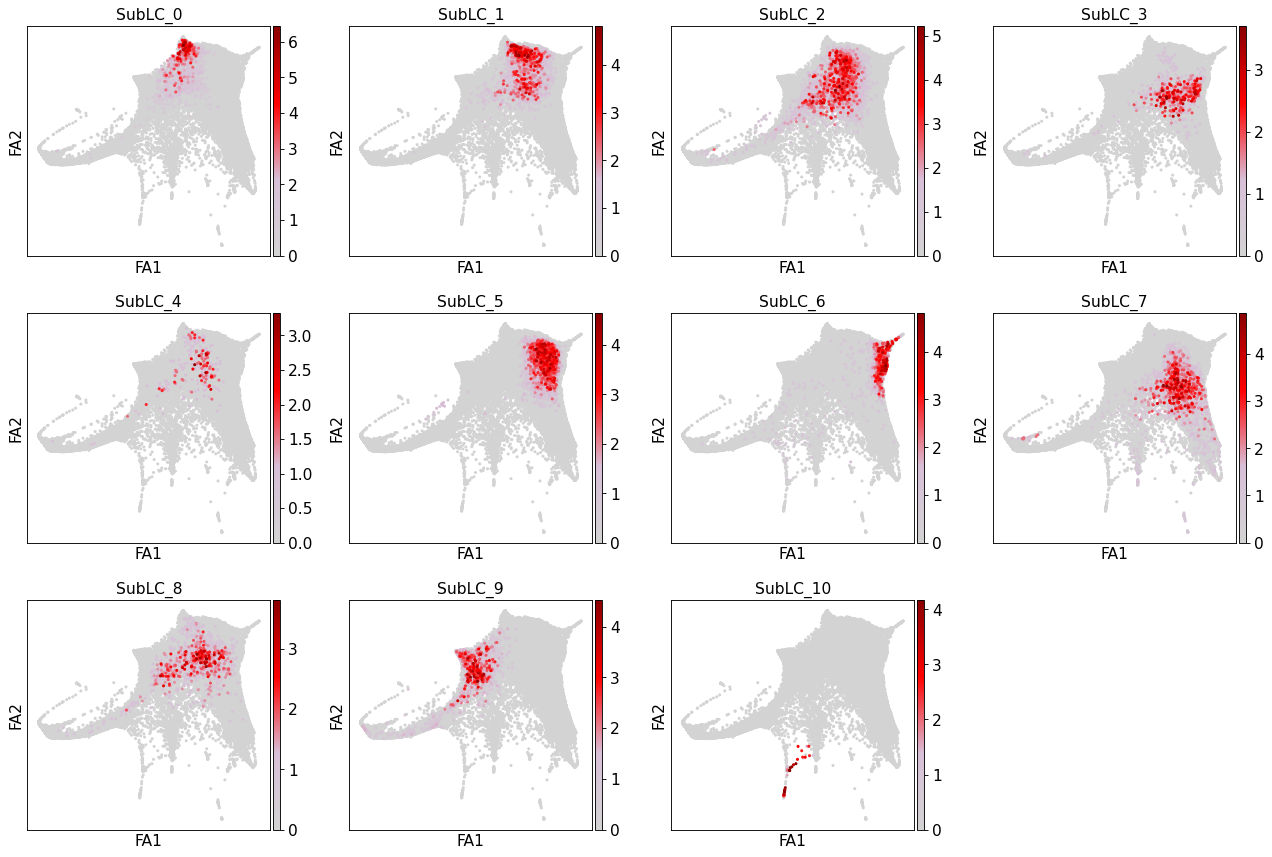

In [37]:
sc.pl.draw_graph(ref_data, color=['SubLC_'+x for x in adata.obs['leiden_v1'].cat.categories], legend_loc="right margin", color_map=cmap, size=30)

In [40]:
Obs_sublabels(ref_data, adata, 'Condition1', cl_assigned, 'SubCon')

['Aldh2KO' 'DKO' 'Fancd2KOhet' 'TKO' 'WT' 'WThet' 'p53KO']


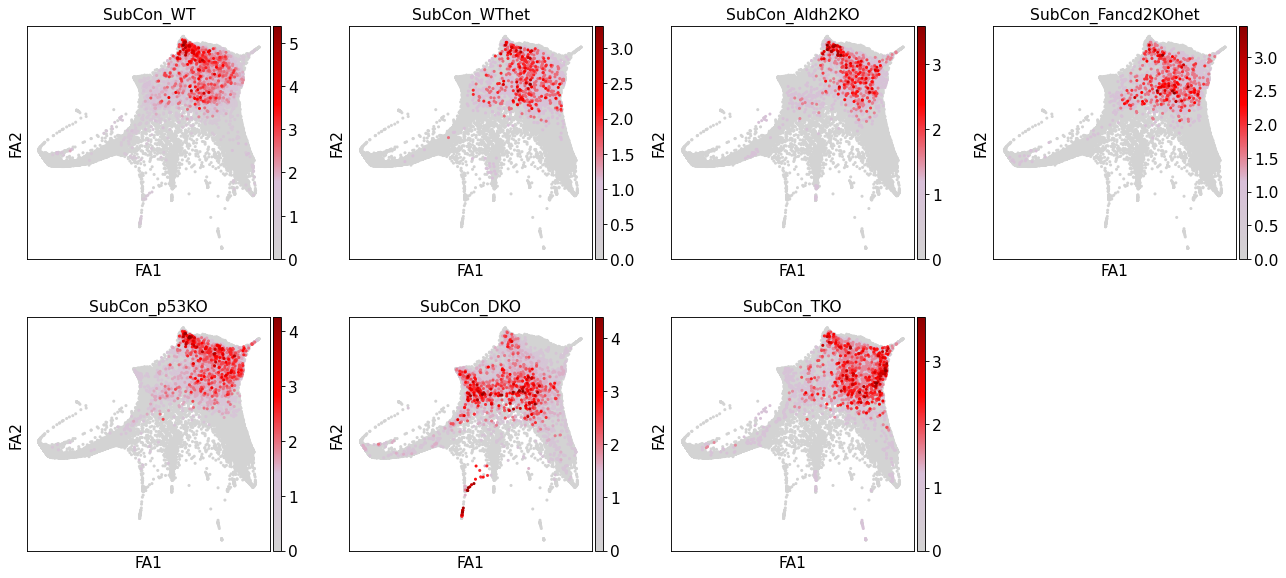

In [41]:
sc.pl.draw_graph(ref_data, color=['SubCon_'+x for x in adata.obs['Condition1'].cat.categories], legend_loc="right margin", color_map=cmap, size=30)

In [42]:
adata.obs['Cell_assigned'] = Rstore['Dahlin_CT']

In [43]:
adata.obs['Cell_assigned'] = adata.obs['Cell_assigned'].astype('category')
adata.obs['Cell_assigned']= adata.obs['Cell_assigned'].cat.reorder_categories(ref_data.obs['CellSubType'].cat.categories)

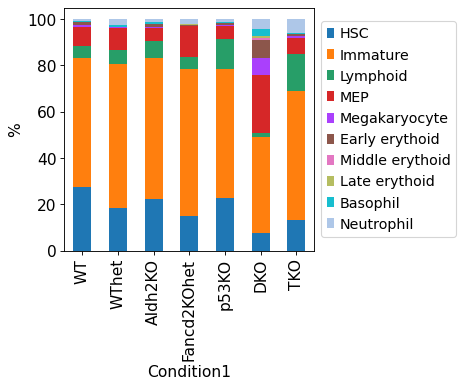

In [44]:
tab1 = pd.crosstab(adata.obs['Condition1'],adata.obs['Cell_assigned'], normalize=0)*100
ax = tab1.plot.bar(stacked=True)
ax.grid(False)
ax.set_ylabel('%')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

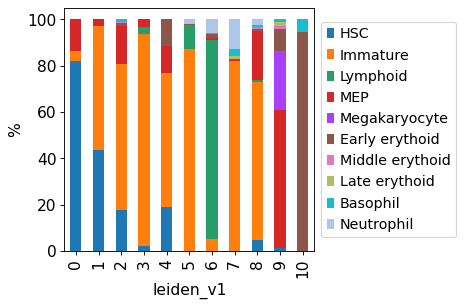

In [45]:
tab2 = pd.crosstab(adata.obs['leiden_v1'],adata.obs['Cell_assigned'], normalize=0)*100
ax = tab2.plot.bar(stacked=True)
ax.grid(False)
ax.set_ylabel('%')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))